## MIDS W207 Fall 2017 Final Project
# Decision Tree and Random Forest Models
Laura Williams, Kim Vignola, Cyprian Gascoigne  
Kaggle Project: San Francisco Crime Classification

## Introduction

In this notebook, we train boosted decision tree and random forest models [and possibly the a bagged tree model] on a dataset from the Kaggle competition called *San Francisco Crime Classification*, which is available here:  
https://www.kaggle.com/c/sf-crime

These models are intended to be run on a modified version of the dataset, so it is intended that this notebook follow implementation of our *Data Set Up* notebook.  Setting up our data included feature engineering, transformations, additional relevant data, and normalization, and is explained in more detail in the *Data Set Up* notebook.

The goal of our models is to predict the type of crime classification, based on time, date, and location features in the dataset from Kaggle, and other data we chose to add in the *Data Set Up* notebook. 

We evaluated our models using a log loss calculation on 20% of held back development data, for which we already had lables. We trained our models for submission to Kaggle on the entire set of training data, and submissed prediction probabilities on the test data to Kaggle for final scoring.

We found that the Random Forest classifier returned the best predictions for this dataset.

#### First import all packages used in this notebook:

In [10]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

#### Extract the modified dataset and load into numpy arrays

In [11]:
# Unzip data files into the "csv" subdirectory 

# **IMPORTANT**  This will overwrite existing files in the "csv" folder in your local repo
# with the most recent data files from the data.zip file

# Unzip 80% training data
unzip_training_data = zipfile.ZipFile("data_subset.zip", "r")
unzip_training_data.extractall()
unzip_training_data.close()

# Unzip development and training data
unzip_test_data = zipfile.ZipFile("testing.zip", "r")
unzip_test_data.extractall()
unzip_test_data.close()

# Unzip full set of training data for creating predictions to submit to Kaggle
unzip_all_data = zipfile.ZipFile("data.zip", "r")
unzip_all_data.extractall()
unzip_all_data.close()

In [12]:
# Load these csv files into numpy arrays for testing on development data
train_data = np.loadtxt('csv/train_data.csv', delimiter=",")
train_labels = np.loadtxt('csv/train_labels.csv', dtype=str, delimiter=",")
dev_data = np.loadtxt('csv/dev_data.csv', delimiter=",")
dev_labels = np.loadtxt('csv/dev_labels.csv', dtype=str, delimiter=",")

In [4]:
# Load these csv files into numpy arrays for creating predictions to submit to Kaggle
train_data_all = np.loadtxt('csv/train_data_all.csv', delimiter=",")
train_labels_all = np.loadtxt('csv/train_labels_all.csv', dtype=str, delimiter=",")
test_data_all = np.loadtxt('csv/test_data_all.csv', delimiter=",")

In [13]:
# print shapes to compare before and after csv conversion
print("train_data shape is", train_data.shape)
print("train_labels shape is", train_labels.shape)
print("dev_data shape is", dev_data.shape)
print("dev_labels shape is", dev_labels.shape)

train_data shape is (702439, 58)
train_labels shape is (702439,)
dev_data shape is (175610, 58)
dev_labels shape is (175610,)


In [6]:
print("train_data_all shape is", train_data_all.shape)
print("train_labels_all shape is", train_labels_all.shape)
print("test_data_all shape is", test_data_all.shape)

train_data_all shape is (878049, 58)
train_labels_all shape is (878049,)
test_data_all shape is (884262, 58)


In [ ]:
# IF there are additional changes to make to the data for this model
# that would be easier to do in pandas, uncomment and run this code. 
# This model works the same whether the data is in numpy or pandas, so presumably so do other models

#train_data = pd.DataFrame(train_data)
#train_labels = pd.DataFrame(train_labels)
#dev_data = pd.DataFrame(dev_data)
#dev_labels = pd.DataFrame(dev_labels)
#train_data_all = pd.DataFrame(train_data_all)
#train_labels_all = pd.DataFrame(train_labels_all)
#test_data_all = pd.DataFrame(test_data_all)

## Random Forest Model
The Random Forest Classifier returned the best log loss scores with default parameters, so chose this as our final model and spent the most time tuning hyperparameters for this model.

The following experiments on an interim dataset returned these optimal parameters:
n_estimators = 150  
max_features = 0.40  
max_depth = 16  

*TO DO*  
Rerun the hyperparameter tuning on our final data set to see if changes to the dataset had any impact on optimal hyperparameters.

In [184]:
# Set up functions for training random forest and finding optimal hyperparameters

def TrainRF(data, labels, test_data, n, depth, features):
    """This function takes as input training data and labels, testing data,
    and can accept different values of hyperparameters, including:
    n (the number of random decision trees to create),
    max_depth (the depth of the tree), and 
    max_features (the subset of features the model randomly selects).
    
    This function trains a random forest model and returns the model and predicted probabilities.
    """
    RF = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=features, n_jobs=1)
    RF.fit(data, labels)
    pp = RF.predict_proba(test_data)
    return RF, pp

def find_max_depth(data, labels, dev_data, dev_labels, n, depth_values, features):
    """Find optimal value of max_depth in a random forest model.  
    
    Note that this cannot be used on test data from Kaggle 
    because we do not have labels for that data.  This function is intended to only be used
    in the development stage with the development data.    
    """
    scores = []
    for depth in depth_values:      
        RF, pp = TrainRF(data, labels, dev_data, n, depth, features)
        logloss = metrics.log_loss(dev_labels, pp)
        scores.append(logloss)
    return scores
        
def find_max_features(data, labels, dev_data, dev_labels, n, depth, num_features):
    """Find optimal value of max_features in a random forest model.  
    
    Note that this cannot be used on test data from Kaggle 
    because we do not have labels for that data.  This function is intended to only be used
    in the development stage with the development data.    
    """
    scores = []
    for f in num_features:      
        RF, pp = TrainRF(data, labels, dev_data, n, depth, f)
        logloss = metrics.log_loss(dev_labels, pp)
        scores.append(logloss)
    return scores


def find_n(data, labels, dev_data, dev_labels, n_values, depth, features):
    """Find optimal value of n in a random forest model.  
    
    Note that this cannot be used on test data from Kaggle 
    because we do not have labels for that data.  This function is intended to only be used
    in the development stage with the development data.
    """
    scores = []
    for n in n_values:      
        RF, pp = TrainRF(data, labels, dev_data, n, depth, features)
        logloss = metrics.log_loss(dev_labels, pp)
        scores.append(logloss)
    return scores

### Tuning hyperparaters
First we experimented with changing one hyperparameter at a time, leaving the remaining parameters at a value with minimal computational cost. This allowed us to quickly cycle through a large range of values for each hyperparameter to more easily target fine-tuning.

In random forests, the same parameters can return slightly different results when run multiple times because the classifer returns a randomly slightly different model every time.  For this reason, we ran each experiment multiple times and plotted the results.

Then we fine-tuned smaller ranges of values with higher computational cost, resulting at an optimal set of hyperparameters on which to train our final model.

#### Maximum depth of the decision tree (max_depth)

We experimented with different ranges of max_depth parameters before settling on the range we tested below.  

With a data set with 58 features, and the number of estimators and maximum number of features set to the default (n=10 and max_features = "sqrt"), we found that the optimal max_depth is usually 16 with a log loss score on the development data of about 2.422 through 2.438, though there is overlap with max_depth values of 15 through 18.

In [114]:
# Set up variables
n = 10
features="sqrt"
depth_values = [1, 3, 5, 7, 9, 11, 13, 14, 15, 16, 17, 18, 19]

# Run multiple iterations and record all scores
iterations = 10
all_depths = np.zeros((iterations, (len(depth_values))))
all_scores = np.zeros((iterations, (len(depth_values))))

for i in range(iterations):
    scores = find_max_depth(train_data, train_labels, dev_data, dev_labels, n, depth_values, features)
    all_depths[i] = depth_values
    all_scores[i] = scores

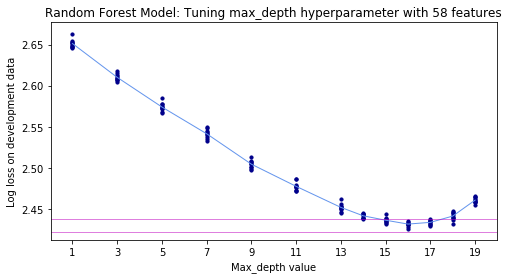

In [158]:
# Set up data for the plot
avg_score_per_depth = np.mean(all_scores, axis=0)

# Plot max_depth results
plt.figure(figsize=(8,4))
x = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
plt.xticks(x)
plt.xlabel("Max_depth value")
plt.ylabel("Log loss on development data")
plt.title("Random Forest Model: Tuning max_depth hyperparameter with 58 features")
plt.plot(depth_values, avg_score_per_depth, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_depths, all_scores, c = "darkblue", s=10)
plt.axhline(y=2.422, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=2.438, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/Max_Depth.png")


#### Maximum number of features in the model (max_features)

We experimented with different subset sizes of features that the random forest classifier randomly selects from the total feature set.  Common values include the square root and log base 2 of the total number of features.  Float values for this parameter will select the percentage of the total features (i.e., a float of 0.10 will select 10% of the features), and the *None* value will use all of the features.

With a dataset of 58 features, with the number of estimators and maximum depth set to low values to minimize testing time (n=10 and max_depth = 5), we found that the optimal number of maximum features with these parameters is about 23 features, which is about 40% of the total feature set, a max_features value of 0.40.  With the non-optimal max_depth, this returned slightly higher log loss values of 2.530 - 2.542.

In [172]:
# Set up variables
n = 10
depth = 5
num_features = [0.05, 'sqrt', 0.10, 'log2', 0.15, 0.20, 0.25, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, None]
num_features_for_plotting = [0.05*train_data.shape[1],
                             np.sqrt(train_data.shape[1]), 
                             0.10*train_data.shape[1],                              
                             np.log2(train_data.shape[1]),
                             0.15*train_data.shape[1],
                             0.20*train_data.shape[1], 
                             0.25*train_data.shape[1],
                             0.30*train_data.shape[1],
                             0.40*train_data.shape[1],
                             0.50*train_data.shape[1],
                             0.60*train_data.shape[1],
                             0.70*train_data.shape[1],
                             0.80*train_data.shape[1],
                             0.90*train_data.shape[1],
                             train_data.shape[1]
                            ]

# Run multiple iterations
iterations = 10
all_num_features = np.zeros((iterations, (len(num_features))), dtype='object')
all_scores_features = np.zeros((iterations, (len(num_features))))

for i in range(iterations):
    scores = find_max_features(train_data, train_labels, dev_data, dev_labels, n, depth, num_features)
    all_num_features[i] = num_features_for_plotting
    all_scores_features[i] = scores

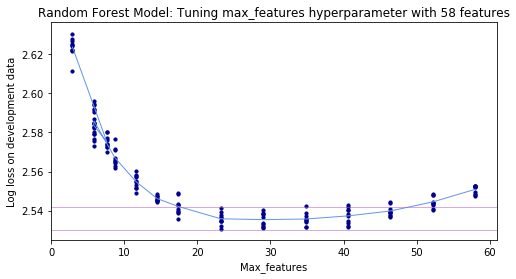

In [181]:
# Set up data for the plot
avg_score_per_num_features = np.mean(all_scores_features, axis=0)

# Plot max_features results
plt.figure(figsize=(8,4))
plt.xlabel("Max_features")
plt.ylabel("Log loss on development data")
plt.title("Random Forest Model: Tuning max_features hyperparameter with 58 features")
plt.plot(num_features_for_plotting, avg_score_per_num_features, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_num_features, all_scores_features, c = "darkblue", s=10)
plt.axhline(y=2.530, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=2.542, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/Max_Features.png")

#### Maximum number of random models (n_estimators)

We experimented with different values for the number of models the random forest classifier creates.

This hyperparameter exacts the most computational cost, so we first tried it out with very small values of the other hyperparameters (max_depth=3 and a feature subset of 10%)

Often random forest models are said to do much better with larger values of n_estimators, bur we found that with the 58 feature data set and a these two other parameters, that we did not get dramatically better results above n = 150. We redid the experiment to look more closely at smaller values of n, and arrived at an optimal value for n_estimators of [add here].

In [191]:
# NOTE: With the default max_depth of None and n_jobs = -1 (using all cores), higher values of n crashed my laptop
# Apparently this is common with random forests
# The fix: limit max_depth and limit n_jobs to 1 core (n_jobs=1 is the default)  
# It takes a bit longer but doesn't crash in the middle of processing --Laura

# Set up variables
n_values = [10, 25, 50, 75, 100, 150, 200, 300, 400, 500, 750, 1000]
depth = 3
features = 0.10

# Run multiple iterations
iterations = 6
all_n_values = np.zeros((iterations, (len(n_values))))
all_scores_n_values = np.zeros((iterations, (len(n_values))))

for i in range(iterations):
    scores = find_n(train_data, train_labels, dev_data, dev_labels, n_values, depth, features)
    all_n_values[i] = n_values
    all_scores_n_values[i] = scores

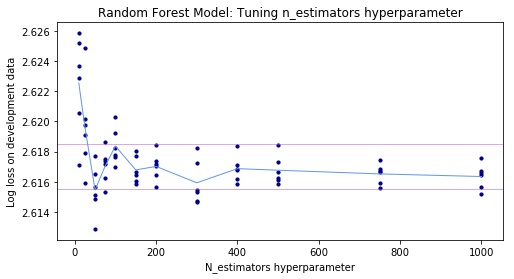

In [201]:
# Set up data for the plot
avg_score_per_n_value = np.mean(all_scores_n_values, axis=0)

# Set up plot
plt.figure(figsize=(8,4))
plt.xlabel("N_estimators hyperparameter")
plt.ylabel("Log loss on development data")
plt.title("Random Forest Model: Tuning n_estimators hyperparameter")
plt.plot(n_values, avg_score_per_n_value, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_n_values, all_scores_n_values, c = "darkblue", s=10)
plt.axhline(y=2.6155, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=2.6185, linewidth=0.5, color = 'mediumorchid')
plt.show()
#plt.savefig("Images/Optimal_N_58_features.png")

In [207]:
# Set up variables to look at smaller values of n
n_values = [10, 25, 50, 75, 100, 150, 200]
depth = 3
features = 0.10

# Run multiple iterations
iterations = 10
all_n_values_small = np.zeros((iterations, (len(n_values))))
all_scores_n_values_small = np.zeros((iterations, (len(n_values))))

for i in range(iterations):
    scores = find_n(train_data, train_labels, dev_data, dev_labels, n_values, depth, features)
    all_n_values_small[i] = n_values
    all_scores_n_values_small[i] = scores

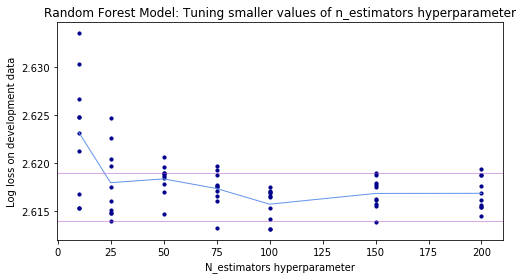

In [208]:
# Set up data for the plot
avg_score_per_n_value_small = np.mean(all_scores_n_values_small, axis=0)

# Set up plot
plt.figure(figsize=(8,4))
plt.xlabel("N_estimators hyperparameter")
plt.ylabel("Log loss on development data")
plt.title("Random Forest Model: Tuning smaller values of n_estimators hyperparameter")
plt.plot(n_values, avg_score_per_n_value_small, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_n_values_small, all_scores_n_values_small, c = "darkblue", s=10)
plt.axhline(y=2.614, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=2.619, linewidth=0.5, color = 'mediumorchid')
plt.show()
#plt.savefig("Images/Optimal_N_Small_58Features.png")

#### Combine optimal hyperparameters
For each hyperparameter above, we isolated variation to that single hyperparameter with non-optimal values of other hyperparameters to reduce computational cost.  Now we combine smaller variations of hyperparameters around its respective optimal value to confirm that they are all working well together. We're looking for the combination to return equal or better log losses to the best values above (which were between 2.422 through 2.438).

*NOTE* This code is taking ahile to run, so I'll try it out and upload it later. --Laura 

In [212]:
# Initialize variable to hold scores
optimal_scores = []

# Set up variables
n_values = [150]
depth_values = [16, 17]
max_features_values = [0.40, 0.50]
iterations = 1

# Run models and record scores
for i in range(iterations):
    for n in n_values:
        for depth in depth_values:
            for features in max_features_values:
                RF = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=features, n_jobs=1)
                RF.fit(train_data, train_labels)
                pp_dev = RF.predict_proba(dev_data)
                logloss_dev = metrics.log_loss(dev_labels, pp_dev)
                # Also fit the model back onto the training dat to test for overfitting
                pp_train = RF.predict_proba(train_data)
                logloss_train = metrics.log_loss(train_labels, pp_train)
                optimal_scores.append([n, features, depth, logloss_dev, logloss_train])
# Print scores
for i in range(len(optimal_scores)):
    print("Model", i+1, "has an of", n, "and max_features of", features, 
    "and max_depth of", depth, "- log loss on dev_data is ", logloss_dev)
    

KeyboardInterrupt: 

In [ ]:
    
# Plot log loss on training data vs. development data
logloss_dev_scores = []
logloss_train_scores = []
for i in range(len(optimal_scores)):
    logloss_dev_scores.append(optimal_scores[i][3])
    logloss_train_scores.append(optimal_scores[i][4])
plt.figure(figsize=(8,4))
plt.xlabel("Log loss score on development data")
plt.ylabel("Log loss score on training data")
plt.title("Overfitting test: compare error on training data to development data")
plt.plot(logloss_dev_scores, logloss_train_scores, c="blueviolet", linewidth=2.0)
# plt.scatter(all_n_values, all_scores_n_values, c = "darkblue", s=10)
#plt.axhline(y=2.530, linewidth=0.5, color = 'mediumorchid')
#plt.axhline(y=2.542, linewidth=0.5, color = 'mediumorchid')
# Is it possible to plot the even diagonal against which to compare?
# plt.plot([0, 1, 2, 3], [0, 1, 2, 33], '--', c="black")
plt.show()

### Final model
After experimenting with all hyperparameters above using 80% of the training data and testing on 20% held back development data, we train a model on the full training set using the best parameters, and create predictions on the test set to submit to Kaggle.

In [8]:
# Train model with optimal hyperparameters on the full set of training data
# Make predictions on the test data
depth = 16
n = 150
features = 0.40
RF, pp = TrainRF(train_data_all, train_labels_all, test_data_all, n, depth, features)

## Boosted Decision Tree
We wanted to try AdaBoost with the Decision Tree Classifier because sometimes this combination does better than the Random Forest classifier.  We tested this model with the dataset that had 58 features. We found that this classidifer did not do better than the Random Forest classifer but it got pretty close.

First we set up some functions for testing the hyperparameters in AdaBoost and the single Decision Tree classifier, because these are somewhat different than the Random Forest Classifier.

In [36]:
# Set up functions for boosted trees and finding optimal hyperparameters

def BoostedTree(data, labels, test_data, learn=1.0, n=10, depth=1):
    """This function takes in training data and labels, testing data,
    and can accept different values of n (number of estimators), 
    max_depth of the decision tree
    and can also accept different values of learning rate for the booster
    
    It trains a Boosted Decision Tree and returns the model and predicted probabilities.
    """
    Boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), 
                               n_estimators=n, 
                               learning_rate=learn)
    Boost.fit(data, labels)
    pp = Boost.predict_proba(test_data)
    return Boost, pp

def find_learning_rate(data, labels, dev_data, dev_labels, learn_values):
    """Find optimal learning rate in an AdaBoost model on a decision tree. 
    
    Note that this cannot be used on test data from Kaggle 
    because we do not have labels for that data.  This function is intended to only be used
    in the development stage with the development data.    
    """
    for learn in learn_values:      
        Boost, pp = BoostedTree(data, labels, dev_data, learn)
        logloss = metrics.log_loss(dev_labels, pp)
        
        # Print log loss for each value of k
        print("For learning rate =", learn, "the Log Loss score is", round(logloss, 6))  
        
def find_n_learn(data, labels, dev_data, dev_labels, learn_values, n_values):
    """There is a tradeoff in boosting between learning rate and n_estimators.
    This function looks for the optimal combination of learning rate and n_estimators.
    """
    for learn in learn_values:
        for n in n_values:
            Boost, pp = BoostedTree(data, labels, dev_data, learn, n)
            logloss = metrics.log_loss(dev_labels, pp)        
            # Print log loss for each combined value of learning rate and n_estimators:
            print("For learning rate =", learn, "and n value", n, "the Log Loss score is", round(logloss, 6))  
        
def find_max_depth(data, labels, dev_data, dev_labels, learn, n, depth_values):
    """Find optimal value of max_depth in the boosted model 
    given optimal combination of learning rate and n_estimators    
    """
    for d in depth_values:      
        BT, pp = BoostedTree(data, labels, dev_data, learn, n, d)
        logloss = metrics.log_loss(dev_labels, pp)        
        # Print log loss for each value
        print("For max_depth =", d, "the Log Loss score is", round(logloss, 6))         


First we trained a boosted decision tree model with some basic hyperparameters, which are a max_depth of 1.0, number of estimators as 10, and a learning rate of 1.0.

In [24]:
Boost, pp = BoostedTree(train_data, train_labels, dev_data)
logloss = metrics.log_loss(dev_labels, pp)
print(logloss)

3.39454132531


#### Learning rate
The first hyperparameter we tested was the learning rate for the AdaBoost classifier. We found an optimal learning rate of 0.01.

In [23]:
# Find the optimal learning rate for default value of n=10 and max_depth of 1.
learn_values = [.0001, .001, .01, .05, .1, .5, 1.0]
find_learning_rate(train_data, train_labels, dev_data, dev_labels, learn_values)

For learning rate = 0.0001 the Log Loss score is 2.647279
For learning rate = 0.001 the Log Loss score is 2.647272
For learning rate = 0.01 the Log Loss score is 2.644091
For learning rate = 0.05 the Log Loss score is 2.658273
For learning rate = 0.1 the Log Loss score is 2.712374
For learning rate = 0.5 the Log Loss score is 3.183055
For learning rate = 1 the Log Loss score is 3.394541


#### Max_depth vs. learning rate
In boosted decision trees, there can be a trade off between learning rate and the number of models create (n_estimators) so while max_depth=1, we iterated through a few learning rate values and value of n. We found a slightly different optimal combination with a learning rate of 0.001 and n=100, but it did not appear to do dramatically better than the previous set of hyperparameters.

In [40]:
n_values = [50, 100, 250]
learn_values = [.0001, .001, .01, .05, .1]
find_n_learn(train_data, train_labels, dev_data, dev_labels, learn_values, n_values)

For learning rate = 0.0001 and n value 50 the Log Loss score is 2.647274
For learning rate = 0.0001 and n value 100 the Log Loss score is 2.647273
For learning rate = 0.0001 and n value 250 the Log Loss score is 2.647309
For learning rate = 0.001 and n value 50 the Log Loss score is 2.647485
For learning rate = 0.001 and n value 100 the Log Loss score is 2.643299
For learning rate = 0.001 and n value 250 the Log Loss score is 2.644949
For learning rate = 0.01 and n value 50 the Log Loss score is 2.662126
For learning rate = 0.01 and n value 100 the Log Loss score is 2.721616
For learning rate = 0.01 and n value 250 the Log Loss score is 2.941801
For learning rate = 0.05 and n value 50 the Log Loss score is 2.939409
For learning rate = 0.05 and n value 100 the Log Loss score is 3.189014
For learning rate = 0.05 and n value 250 the Log Loss score is 3.434238
For learning rate = 0.1 and n value 50 the Log Loss score is 3.187824
For learning rate = 0.1 and n value 100 the Log Loss score is

#### Max_depth
We looked at some different values of max_depth to see if they would improve the model. We found an optimal max_depth of 8.

In [39]:
learn = .01
n = 10
depth_values = [3, 5, 6, 7, 8, 9]
find_max_depth(train_data, train_labels, dev_data, dev_labels, learn, n, depth_values)

For max_depth = 3 the Log Loss score is 2.589809
For max_depth = 5 the Log Loss score is 2.548867
For max_depth = 6 the Log Loss score is 2.527923
For max_depth = 7 the Log Loss score is 2.509453
For max_depth = 8 the Log Loss score is 2.504026
For max_depth = 9 the Log Loss score is 2.521608


#### Final testing of the Boosted Decision Tree classifier
We tried out a more granular set of max_depth with the optimal combination of learning rate and n_estimators we found above.  The classifier created a better model here than anywhere above, with a max_depth of 8, a learning rate of 0.001 and n_estiimators value of 100, but it still did not do better than the random forest model.

In [41]:
# See if changes to max_depth improves the model with a optimal specific learning rate and n
learn = 0.001
n = 100
depth_values = [5, 6, 7, 8, 9, 10]
find_max_depth(train_data, train_labels, dev_data, dev_labels, learn, n, depth_values)

For max_depth = 5 the Log Loss score is 2.548683
For max_depth = 6 the Log Loss score is 2.527825
For max_depth = 7 the Log Loss score is 2.50858
For max_depth = 8 the Log Loss score is 2.502424
For max_depth = 9 the Log Loss score is 2.518338
For max_depth = 10 the Log Loss score is 2.567408


## Bagged Trees

In [ ]:
# Set up functions for training bagged trees and finding optimal hyperparameters

# TBD, requires writing some code outside of sk learn



## Create zipped csv file of probabilities to submit to Kaggle
This code uses the predicted probabilities from the most recent model trained in this notebook, saved as the variable pp

In [9]:
# Set up predictions for submission to Kaggle 


headers = ["ARSON","ASSAULT","BAD CHECKS","BRIBERY","BURGLARY","DISORDERLY CONDUCT","DRIVING UNDER THE INFLUENCE",
           "DRUG/NARCOTIC","DRUNKENNESS","EMBEZZLEMENT","EXTORTION","FAMILY OFFENSES","FORGERY/COUNTERFEITING",
           "FRAUD","GAMBLING","KIDNAPPING","LARCENY/THEFT","LIQUOR LAWS","LOITERING","MISSING PERSON","NON-CRIMINAL",
           "OTHER OFFENSES","PORNOGRAPHY/OBSCENE MAT","PROSTITUTION","RECOVERED VEHICLE","ROBBERY","RUNAWAY",
           "SECONDARY CODES","SEX OFFENSES FORCIBLE","SEX OFFENSES NON FORCIBLE","STOLEN PROPERTY","SUICIDE",
           "SUSPICIOUS OCC","TREA","TRESPASS","VANDALISM","VEHICLE THEFT","WARRANTS","WEAPON LAWS"]
data = pd.DataFrame(data=pp, 
                    index=[x for x in range(len(test_data_all))], 
                    columns=headers)
data.columns.name ="Id"
print(data)

Id         ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  \
0       0.000873  0.041185    0.000029  0.000063  0.013059   
1       0.000873  0.041185    0.000029  0.000063  0.013059   
2       0.000873  0.041185    0.000029  0.000063  0.013059   
3       0.000873  0.041185    0.000029  0.000063  0.013059   
4       0.000873  0.041185    0.000029  0.000063  0.013059   
5       0.000873  0.041185    0.000029  0.000063  0.013059   
6       0.000873  0.041185    0.000029  0.000063  0.013059   
7       0.000873  0.041185    0.000029  0.000063  0.013059   
8       0.000873  0.041185    0.000029  0.000063  0.013059   
9       0.000873  0.041185    0.000029  0.000063  0.013059   
10      0.000873  0.041185    0.000029  0.000063  0.013059   
11      0.000873  0.041185    0.000029  0.000063  0.013059   
12      0.000873  0.041185    0.000029  0.000063  0.013059   
13      0.000873  0.041185    0.000029  0.000063  0.013059   
14      0.000873  0.041185    0.000029  0.000063  0.013059   
15      

Create zipped csv file for Kaggle
#### Update the filename first in all lines of the following code
Add something unique after our names to avoid overwriting other submission files

In [10]:
data.to_csv('Williams_Gascoigne_Vignola_RandomForest1.csv', index_label = "Id")

In [17]:
zip_probs = zipfile.ZipFile("Williams_Gascoigne_Vignola_RandomForest1.zip", "w")
zip_probs.write("Williams_Gascoigne_Vignola_RandomForest1.csv", compress_type=zipfile.ZIP_DEFLATED)
zip_probs.close()### Results from previous datasets and/or model parameters

### Results from previous datasets and/or model parameters

Random forest model on dataset as of 11/18 (weather added, binarized, normalized) with max_depth set to 15 and n_estimators set to 1000 returned log loss on development data of 2.404.